In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from glob import glob

In [2]:
# path to detectin results
detect_res_path = "../exp/"
detect_labels_res_path = os.path.join(detect_res_path, "labels")

# path to true labels
true_labeled_imgs_path = "../create_train_set/data/rgb_images_spag_&_bckg"
true_labels_path = "../yolo-labels/"

In [3]:
detect_res_img_paths = glob(os.path.join(detect_res_path, "*"))
detect_txt_res_paths = glob(os.path.join(detect_labels_res_path, "*"))

true_labeled_img_paths = glob(os.path.join(true_labeled_imgs_path, "*"))
true_labels_paths = glob(os.path.join(true_labels_path, "*"))

In [4]:
def get_basename_no_ext(inp):
    return os.path.splitext(os.path.basename(inp[0]))[0]

def get_basenames_no_ext_arr(arr):
    arr_base = np.array(arr).reshape(-1,1)
    arr_base = np.apply_along_axis(get_basename_no_ext, 1, arr_base)
    return arr_base

def read_conf(img_name, detect_txt_res_paths):
    detect_txt_res_paths_base = get_basenames_no_ext_arr(detect_txt_res_paths)
    img_name_no_ext = os.path.splitext(os.path.basename(img_name))[0]
    
    if img_name_no_ext not in detect_txt_res_paths_base:
        return None
    txt_path = f"{os.path.dirname(detect_txt_res_paths[0])}/{img_name_no_ext}.txt"
    conf = []
    with open(txt_path) as fp:
        for line in fp:
            line = line.split(" ")
            if len(line) == 5:
                # print("ERROR: no conf saved")
                continue
            conf.append(float(line[5].strip()))
    return conf

def check_existance(img_name, true_labels_paths):
    true_labels_paths_base = get_basenames_no_ext_arr(true_labels_paths)
    img_name_no_ext = os.path.splitext(os.path.basename(img_name))[0]
    
    if img_name_no_ext in true_labels_paths_base:
        return True
    else:
        return False

def get_rows(detect_res_img_paths, detect_txt_res_paths, true_labeled_img_paths, true_labels_paths):
    rows = []
    for img_name in detect_res_img_paths:
        conf = read_conf(img_name, detect_txt_res_paths)
        
        true_result = check_existance(img_name, true_labels_paths)
        is_valid = check_existance(img_name, true_labeled_img_paths)
        
        im_name_base = os.path.basename(img_name)
        if conf is not None:
            for box_conf in conf:
                rows.append([im_name_base, box_conf, true_result, is_valid])
        else:
            rows.append([im_name_base, 0.0, true_result, is_valid])
    return rows

In [5]:
rows = get_rows(detect_res_img_paths, detect_txt_res_paths, true_labeled_img_paths, true_labels_paths)
rows_df = pd.DataFrame(rows, columns=['img_name', 'conf', 'true_res', 'is_valid'])

In [6]:
rows_df_grouped = rows_df.groupby(['img_name'])
imgs = rows_df.img_name.unique()
false_positives = pd.DataFrame()
for img in imgs:
    img_group = rows_df_grouped.get_group(img)
    
    # in event of false positive
    for bbox in range(len(img_group)):
        row = img_group.iloc[bbox]
        if (row.true_res == False) and (row.conf != 0.0):
            false_positives = false_positives.append(row)
    # break


In [7]:
false_positives

,img_name,conf,true_res,is_valid
0,example.jpeg,0.173019,0.0,0.0
1,example.jpeg,0.481946,0.0,0.0
5,186.alternative_filaments-1280x720.jpg,0.078362,0.0,0.0
6,186.alternative_filaments-1280x720.jpg,0.105384,0.0,0.0
7,186.alternative_filaments-1280x720.jpg,0.246175,0.0,0.0
...,...,...,...,...
1131,180.1920x1080.jpeg,0.070274,0.0,0.0
1132,180.1920x1080.jpeg,0.083552,0.0,0.0
1133,180.1920x1080.jpeg,0.150215,0.0,0.0
1134,180.1920x1080.jpeg,0.298592,0.0,0.0


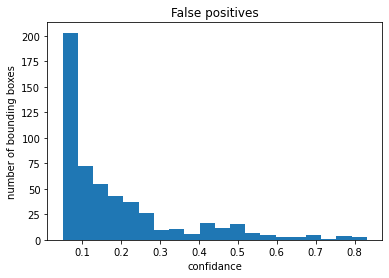

In [8]:
plt.hist(false_positives.conf, bins=20)
plt.ylabel('number of bounding boxes')
plt.xlabel('confidance')
plt.title('False positives');

In [9]:
false_positives.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537 entries, 0 to 1135
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_name  537 non-null    object 
 1   conf      537 non-null    float64
 2   true_res  537 non-null    float64
 3   is_valid  537 non-null    float64
dtypes: float64(3), object(1)
memory usage: 21.0+ KB
